In [5]:
# 1. Imports and Setup

import pandas as pd
import ast
import sys
import re
import os
sys.path.append(os.path.abspath("../src"))
from collections import Counter
project_root = os.path.abspath("..")
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
data_path = os.path.join(project_root, "data", "reviews_with_sentiment.csv")
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Adjust based on your project structure
sys.path.append(root_dir)
from script.visualization import plot_sentiment_trends, plot_rating_distribution, plot_keyword_cloud
df = pd.read_csv(data_path)

from script.insights import extract_drivers_painpoints, compare_banks
from script.recommendations import generate_recommendations
from script.visualization import plot_sentiment_trends, plot_rating_distribution, plot_keyword_cloud
from script.ethics import note_biases
df = df.drop(['user_name', 'review_id'], axis=1)
print(df.columns)
print(df.head())


Index(['rating', 'date', 'review', 'bank', 'source', 'sentiment_label',
       'sentiment_score'],
      dtype='object')
   rating                 date  \
0       5  2025-06-09 18:31:56   
1       5  2025-06-09 16:20:06   
2       4  2025-06-09 11:49:09   
3       1  2025-06-09 01:24:23   
4       5  2025-06-08 21:52:23   

                                              review bank       source  \
0                         So bad now and hard to use  CBE  Google Play   
1  it is so amazing app. but, it is better to upd...  CBE  Google Play   
2                                         v.good app  CBE  Google Play   
3                                      very good app  CBE  Google Play   
4           Very amazing app indeed. I'm enjoying it  CBE  Google Play   

  sentiment_label  sentiment_score  
0        negative         0.999806  
1        positive         0.949643  
2        positive         0.995270  
3        positive         0.999868  
4        positive         0.999882  


In [6]:
def map_rating_to_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating <= 2:
        return 'negative'
    else:
        return 'neutral'

df['derived_sentiment'] = df['rating'].apply(map_rating_to_sentiment)
print(df['derived_sentiment'].value_counts()) 

def get_top_words(texts, n=5):
    words = []
    for text in texts:
        tokens = re.findall(r'\b[a-z]{3,}\b', str(text).lower())
        words.extend([w for w in tokens if w not in ENGLISH_STOP_WORDS])
    return [w for w, _ in Counter(words).most_common(n)]

def extract_drivers_painpoints(
    df,
    sentiment_col='derived_sentiment',  
    text_col='review',
    bank_col='bank'
):
    insights = {}
    for bank in df[bank_col].unique():
        bank_df = df[df[bank_col] == bank]
        pos_texts = bank_df[bank_df[sentiment_col] == 'positive'][text_col]
        neg_texts = bank_df[bank_df[sentiment_col] == 'negative'][text_col]
        insights[bank] = {
            'drivers': get_top_words(pos_texts),
            'painpoints': get_top_words(neg_texts)
        }
    return insights

insights = extract_drivers_painpoints(df)
print(insights)

derived_sentiment
positive    847
negative    290
neutral      63
Name: count, dtype: int64
{'CBE': {'drivers': ['app', 'good', 'best', 'nice', 'cbe'], 'painpoints': ['app', 'good', 'banking', 'bank', 'screenshot']}, 'BOA': {'drivers': ['good', 'app', 'best', 'boa', 'nice'], 'painpoints': ['app', 'bank', 'work', 'mobile', 'banking']}, 'Dashen': {'drivers': ['app', 'dashen', 'banking', 'super', 'bank'], 'painpoints': ['app', 'good', 'bank', 'slow', 'working']}}


In [7]:
## Recommendations
recommendations = generate_recommendations(insights)
for bank, recs in recommendations.items():
    print(f"Recommendations for {bank}:")
    for rec in recs[:2]:  # At least 2 improvements
        print(" -", rec)
    print()

Recommendations for CBE:
 - Address customer concern: 'app' (e.g., improve this area)
 - Address customer concern: 'good' (e.g., improve this area)

Recommendations for BOA:
 - Address customer concern: 'app' (e.g., improve this area)
 - Address customer concern: 'bank' (e.g., improve this area)

Recommendations for Dashen:
 - Address customer concern: 'app' (e.g., improve this area)
 - Address customer concern: 'good' (e.g., improve this area)



e:\KAIM\Customer-Experience-Analytics-for-Fintech-Apps\script\visualization.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  trend = df.groupby([bank_col, pd.Grouper(key=date_col, freq='M')])[sentiment_col].value_counts().unstack().fillna(0)


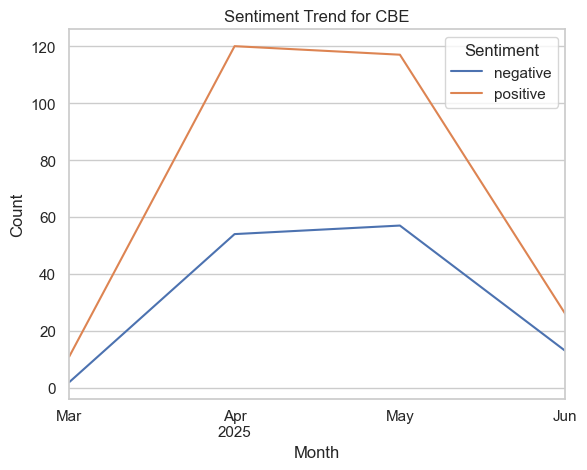

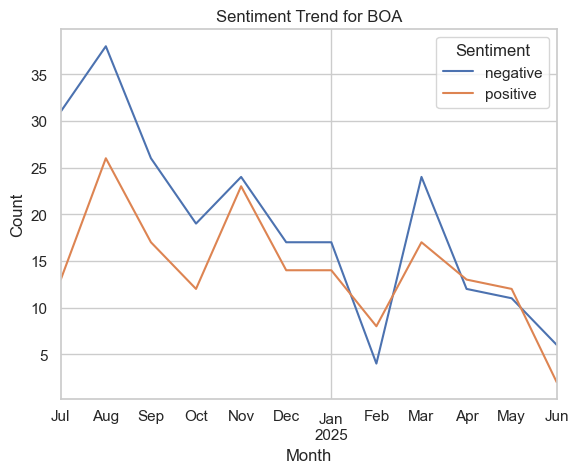

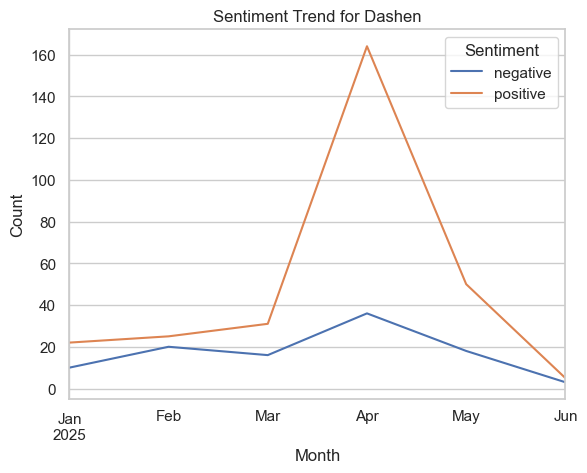

In [8]:
# 1. Sentiment trends over time
plot_sentiment_trends(df, date_col='date', sentiment_col='sentiment_label', bank_col='bank')

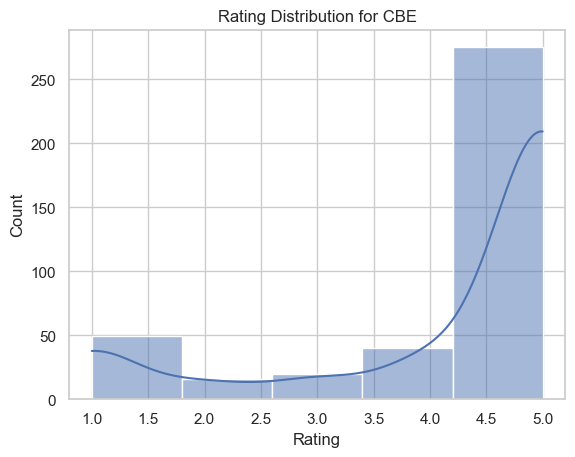

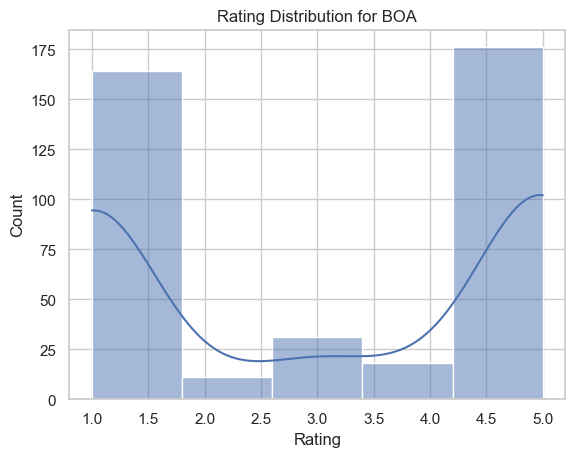

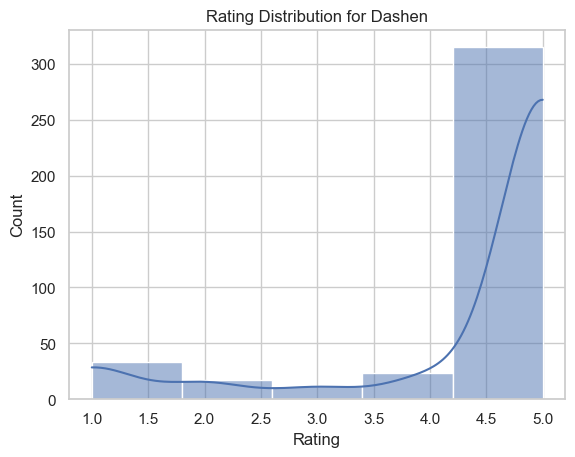

In [9]:
# 2. Rating distribution for each bank
plot_rating_distribution(df, rating_col='rating', bank_col='bank')

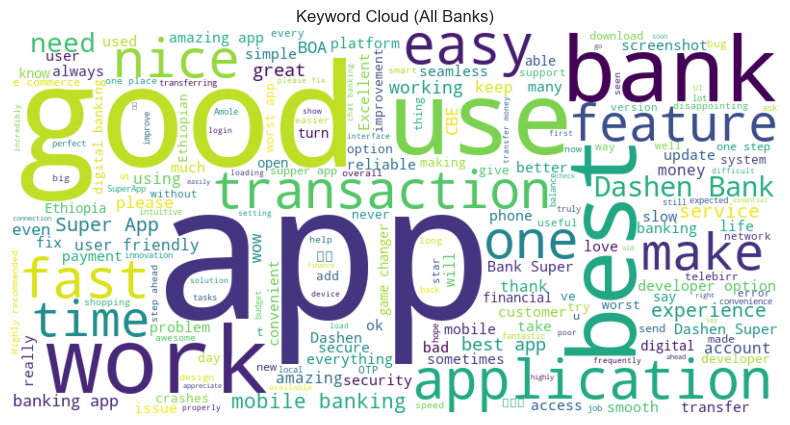

In [10]:
# 3. Keyword cloud for all banks
plot_keyword_cloud(df, text_col='review')

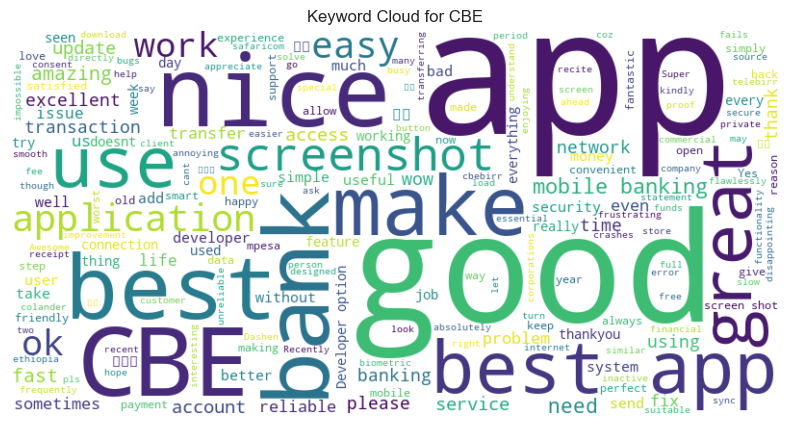

In [ ]:
# 4. Keyword cloud for CBE
plot_keyword_cloud(df, text_col='review', bank='CBE', bank_col='bank')

In [16]:
sentiment_col = 'sentiment_label'
bank_col = 'bank'

# Count occurrences of each sentiment per bank
count_df = df.groupby([bank_col, sentiment_col]).size().reset_index(name='count')

# Calculate total count per bank
total_per_bank = df.groupby(bank_col).size().reset_index(name='total')

# Merge the counts
merged_df = count_df.merge(total_per_bank, on=bank_col)

# Calculate percentage
merged_df['percent'] = (merged_df['count'] / merged_df['total']) * 100

# Optional: format percent
merged_df['percent'] = merged_df['percent'].round(2)

print(merged_df)


     bank sentiment_label  count  total  percent
0     BOA        negative    229    400    57.25
1     BOA        positive    171    400    42.75
2     CBE        negative    126    400    31.50
3     CBE        positive    274    400    68.50
4  Dashen        negative    103    400    25.75
5  Dashen        positive    297    400    74.25


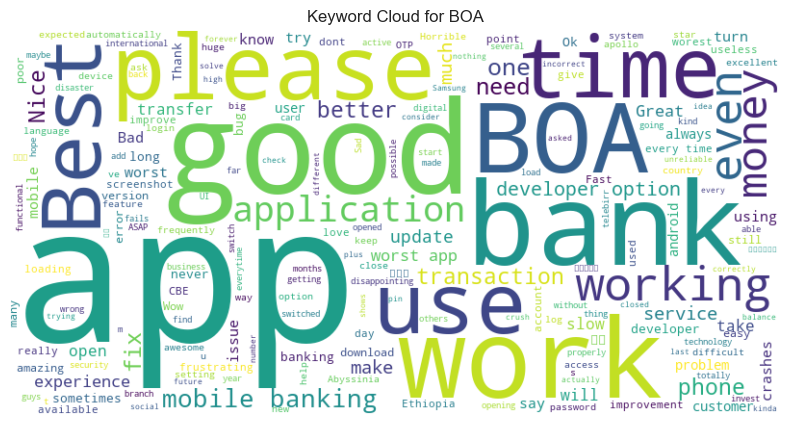

In [ ]:
# 4. Keyword cloud for BOA
plot_keyword_cloud(df, text_col='review', bank='BOA', bank_col='bank')

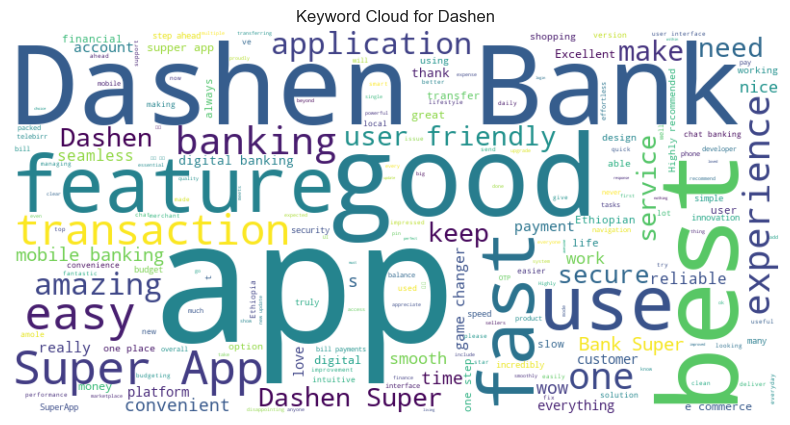

In [17]:
# 4. Keyword cloud for Dashen
plot_keyword_cloud(df, text_col='review', bank='Dashen', bank_col='bank')

In [12]:
## Ethics: Review Biases

bias_note = note_biases(df, sentiment_col='sentiment_label')
print(bias_note)

Out of 1200 reviews, 458 are negative (38.2%), 742 are positive (61.8%). There is a notable positive skew, which may indicate review bias (e.g., incentivized or solicited positive reviews).
Consider these biases when interpreting insights and recommendations.
